# Определение стоимости автомобилей

## Подготовка данных

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [2]:
car_data = pd.read_csv('/datasets/autos.csv')

In [3]:
display(car_data.info())
car_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
car_data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


При первом взгляде на датасет заметно, что в нем есть пропуски, а также много ненужных столбцов, например:

+ DateCrawled — дата скачивания анкеты из базы
+ RegistrationMonth — месяц регистрации автомобиля
+ DateCreated — дата создания анкеты
+ NumberOfPictures — количество фотографий автомобиля
+ PostalCode — почтовый индекс владельца анкеты (пользователя)
+ LastSeen — дата последней активности пользователя

Избавимся от них и перейдем к обратке пропусков.

In [5]:
cars_data = car_data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis='columns')


In [6]:
display(cars_data.info())
cars_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


None

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Пропуски есть в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired. Заменим NaN-ы нетипичным значением unk - модель воспримет их как отдельную категорию.

In [7]:
cars_data.fillna(value='unk', inplace=True)
cars_data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unk,1993,manual,0,golf,150000,petrol,volkswagen,unk
1,18300,coupe,2011,manual,190,unk,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unk
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Проверим датасет на наличие выбросов.

<AxesSubplot:>

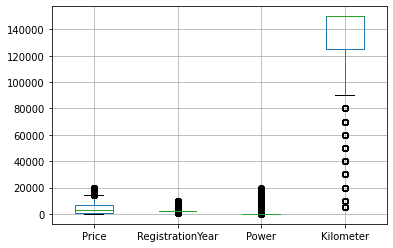

In [8]:
cars_data.boxplot()

Пробег и цену трогать не будем - здесь значения могут быть самыми разными. А вот выбросы в столбцах RegistrationYear и Power интересны - например, мощностью больше 1000 лошадиных сил могут похвастаться только спротивные автомобили, а год регистрации не может быть больше 2022 и меньше 1931, когда был зарегистрирован первый автомобиль.

In [9]:
cars_data.shape

(354369, 10)

In [10]:
#Код ревьюера
cars_data = cars_data.query('RegistrationYear <= 2016 and RegistrationYear >= 1931 and Power <= 1200')

In [11]:
cars_data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 2016,
       2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982,
       1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1970, 1965, 1945,
       1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961, 1960, 1966, 1975,
       1963, 1964, 1954, 1958, 1967, 1959, 1956, 1941, 1962, 1957, 1940,
       1949, 1937, 1951, 1953, 1933, 1950, 1948, 1952, 1932, 1942, 1935,
       1936, 1944, 1943, 1934, 1938, 1931, 1947, 1946])

## Обучение  и анализ моделей

Задействуем технику прямого кодирования, чтобы преобразовать категориальные признаки в численные.

In [12]:
cars_data_ohe = pd.get_dummies(cars_data, drop_first=True)

In [13]:
# Код ревьюера
cars_data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unk,NotRepaired_yes
0,480,1993,0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Подготовим признаки и целевой признак, а затем разделим данные на обучающую и тестовую выборки.

In [14]:
#признаки для обучения модели линейной регрессии
features_lr = cars_data_ohe.drop(['Price'], axis = 1)
target_lr = cars_data_ohe['Price']

Преобразуем столбцы с категориальными признаками в тип данных category

In [15]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [16]:
for col in categorical:
    cars_data[col] = cars_data[col].astype('category')

In [17]:
#признаки для обучения моделей CBR и LGBM
features = cars_data.drop(['Price'], axis = 1)
target = cars_data['Price']

In [18]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(features_lr, target_lr, test_size=.25, random_state=12345)

In [19]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=12345)

In [20]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr.shape

(        RegistrationYear  Power  Kilometer  VehicleType_convertible  \
 298313              1999    218     150000                        0   
 42546               2012    140      60000                        0   
 175923              2002     58     125000                        0   
 294498              2005    101     150000                        0   
 321836              2013    116      50000                        0   
 ...                  ...    ...        ...                      ...   
 165726              2003     84     150000                        0   
 49983               1990     50     150000                        0   
 90118               2009    102     150000                        0   
 80606               2004    140     150000                        0   
 227131              2005    224     150000                        0   
 
         VehicleType_coupe  VehicleType_other  VehicleType_sedan  \
 298313                  0                  0                  0  

In [21]:
features_train, features_test, target_train, target_test.shape

(       VehicleType  RegistrationYear Gearbox  Power     Model  Kilometer  \
 298313         suv              1999    auto    218  m_klasse     150000   
 42546        wagon              2012  manual    140    passat      60000   
 175923       small              2002  manual     58     other     125000   
 294498         bus              2005  manual    101    meriva     150000   
 321836       coupe              2013  manual    116       1er      50000   
 ...            ...               ...     ...    ...       ...        ...   
 165726       sedan              2003  manual     84   primera     150000   
 49983        small              1990  manual     50     justy     150000   
 90118        sedan              2009  manual    102     caddy     150000   
 80606        sedan              2004  manual    140    passat     150000   
 227131       sedan              2005    auto    224  e_klasse     150000   
 
         FuelType          Brand NotRepaired  
 298313    petrol  mercedes

In [22]:
#напишем формулу для получения значения метрики RMSE
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

Обучим и проанализируем время работы и качество моделей.

# LinearRegression

In [23]:
lr_model = LinearRegression()

In [24]:
%%time
lr_model.fit(features_train_lr, target_train_lr)

CPU times: user 38.8 s, sys: 46.7 s, total: 1min 25s
Wall time: 1min 25s


LinearRegression()

In [25]:
%%time
predicted_lr = pd.Series(lr_model.predict(features_test_lr))

CPU times: user 206 ms, sys: 179 ms, total: 385 ms
Wall time: 385 ms


In [26]:
rmse(target_test_lr, predicted_lr)

2760.7785613130814

# CatBoostRegressor

In [27]:
#построим модель CBR и исследуем её работу с различными значениями гиперпараметра iterations с помощью кросс-валидации
for iteration in range(10, 111, 25):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=iteration, depth=10, verbose=10, cat_features=categorical)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=2)
    print("Score при iterations =", iteration, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

Learning rate set to 0.5
0:	learn: 3135.0838491	total: 150ms	remaining: 1.35s
9:	learn: 1876.6074971	total: 923ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3150.2613221	total: 86.6ms	remaining: 779ms
9:	learn: 1858.3482942	total: 923ms	remaining: 0us
Score при iterations = 10 : [0.82564921 0.82413942]
Score mean = 0.824894316412616

Learning rate set to 0.5
0:	learn: 3135.0838491	total: 102ms	remaining: 3.47s
10:	learn: 1866.2250422	total: 956ms	remaining: 2.09s
20:	learn: 1760.2188308	total: 1.79s	remaining: 1.2s
30:	learn: 1697.3868746	total: 2.62s	remaining: 339ms
34:	learn: 1685.1033214	total: 2.98s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3150.2613221	total: 95.5ms	remaining: 3.25s
10:	learn: 1848.7198347	total: 965ms	remaining: 2.11s
20:	learn: 1751.0822624	total: 1.82s	remaining: 1.21s
30:	learn: 1675.8109840	total: 2.69s	remaining: 347ms
34:	learn: 1658.3652032	total: 3.05s	remaining: 0us
Score при iterations = 35 : [0.84589477 0.8436015 ]
Score mean = 0.844748

In [28]:
#исследуем работу модели с различными значениями гиперпараметра depth
for depth in range(5, 16, 2):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=20, depth=depth, verbose=10, cat_features=categorical)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=2)
    print("Score при depth =", depth, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

Learning rate set to 0.5
0:	learn: 3354.7690283	total: 62.2ms	remaining: 1.18s
10:	learn: 2066.7076318	total: 508ms	remaining: 416ms
19:	learn: 1971.8047027	total: 877ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3368.8176983	total: 58.4ms	remaining: 1.11s
10:	learn: 2056.6851906	total: 585ms	remaining: 478ms
19:	learn: 1970.4400392	total: 996ms	remaining: 0us
Score при depth = 5 : [0.81391212 0.80999174]
Score mean = 0.8119519267210422

Learning rate set to 0.5
0:	learn: 3245.1627066	total: 86.4ms	remaining: 1.64s
10:	learn: 1977.2526813	total: 807ms	remaining: 661ms
19:	learn: 1897.4884358	total: 1.37s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3267.8748141	total: 90.7ms	remaining: 1.72s
10:	learn: 1964.1426362	total: 793ms	remaining: 649ms
19:	learn: 1887.4670328	total: 1.4s	remaining: 0us
Score при depth = 7 : [0.82480362 0.82190467]
Score mean = 0.8233541427455593

Learning rate set to 0.5
0:	learn: 3164.4717368	total: 111ms	remaining: 2.11s
10:	learn: 1891.7021002	t

Можно отметить, что при увеличении iterations модель сначала дает намного бОльшую точность (в 2 раза), затем увеличение точности начинает снижаться, до тех пор, пока разница не становится совсем незначительной. Нужно помнить, что скорость обучения модели для нас важна так же, как и точность ее работы, поэтому не будем жертвовать скоростью и выберем оптимальный вариант с числом iterations 85.

При изменении параметра depth прослеживается такая же тенденция, поэтому оптимальной глубиной будет число 13.

Измерим время обучения и работы модели со значением iterations = 90 и depth = 11.

In [29]:
cat_model_90_11= CatBoostRegressor(loss_function="RMSE", iterations=90, depth=11, verbose=10)

In [30]:
%%time
cat_model_90_11.fit(features_train, target_train, cat_features=categorical)

Learning rate set to 0.5
0:	learn: 3103.0181426	total: 244ms	remaining: 21.7s
10:	learn: 1812.6694723	total: 2.44s	remaining: 17.6s
20:	learn: 1731.0852916	total: 4.59s	remaining: 15.1s
30:	learn: 1658.6923732	total: 6.96s	remaining: 13.3s
40:	learn: 1612.7195691	total: 9.34s	remaining: 11.2s
50:	learn: 1581.0668345	total: 11.6s	remaining: 8.89s
60:	learn: 1557.4410926	total: 13.9s	remaining: 6.59s
70:	learn: 1537.1047290	total: 16.2s	remaining: 4.34s
80:	learn: 1515.8843260	total: 18.3s	remaining: 2.04s
89:	learn: 1497.3205062	total: 20.2s	remaining: 0us
CPU times: user 19.6 s, sys: 101 ms, total: 19.7 s
Wall time: 21.3 s


In [31]:
%%time
predicted_cat_90_11 = pd.Series(cat_model_90_11.predict(features_test))


CPU times: user 108 ms, sys: 4.68 ms, total: 113 ms
Wall time: 127 ms


In [32]:
rmse(target_test, predicted_cat_90_11)

1716.3732109038617

# LightGBM

In [33]:
%%time

lgbmmodel = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=100, 
                      random_state=12345,max_depth=6)
lgbmmodel.fit(features_train, target_train)

CPU times: user 8min 8s, sys: 6.44 s, total: 8min 15s
Wall time: 8min 19s


LGBMRegressor(max_depth=6, num_leaves=100, random_state=12345)

In [34]:
%%time
predictions_lgbm = lgbmmodel.predict(features_test)

CPU times: user 935 ms, sys: 0 ns, total: 935 ms
Wall time: 914 ms


In [35]:
rmse(target_test, predictions_lgbm)

1725.3502947506508

# Вывод

Сравним полученные результаты

In [36]:
models = [['LR', 25.2, 301, 2786], ['CBR', 16.5, 103, 1742], 
       ['LGB', 8.3, 983, 1775]] 
    
df = pd.DataFrame(models, columns =['model', 'train_time, sec', 'work_time, msec', 'rmse']) 
df 

,model,"train_time, sec","work_time, msec",rmse
0,LR,25.2,301,2786
1,CBR,16.5,103,1742
2,LGB,8.3,983,1775


Скорость предсказания любой модели значительно меньше, чем её обучение. Важно, чтобы время предсказания было как можно меньше - обучаем модель мы только один раз, но предсказывать она может до бесконечности.

Метрика RMSE лучше всего выглядит у модели CBR. Быстрее всего обучается модель LGB,а метрика RMSE прктически одинакова по сравнению с моделью CBR - данную модель можно посоветовать сервису как прототип. Модель LR показала худшие результаты по значениям метрики и по скорости работы.  